In [ ]:
import pandas as pd
import datetime
import tensorflow as tf
import keras
import seaborn
import numpy as np

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

from matplotlib import pyplot



In [ ]:
# Create fixed-window sequences for training and validation data
def create_sequences(X, window_size):
    seq_X = []
    seq_y = []
    for i in range(len(X) - window_size):
        seq_X.append(X[i:i+window_size])
        seq_y.append(X[i+window_size])
    return seq_X, seq_y

In [ ]:
def reprocess(y, details):
    # print(details)
    mean = details[2][0]
    std = details[2][1]
    PF = details[2][2]
    PFtype = details[2][3]
    time = details[3]

    # print("mean:", mean, "std:", std, "PF", PF, "type", PFtype, "time", time)

    if(PFtype == 1):
        return ((y * std) + mean) * np.exp(PF[0] * time + PF[1])    
    # print("here")
    return (y * std + mean) * (PF[0] * np.square(time) + PF[1] * time + PF[2])


In [ ]:
def preprocess(data):
    PFtype = -1
    PF1 = np.polyfit(np.linspace(0,len(data) - 1,num=len(data)), np.log(data), 1)
    PF2 = np.polyfit(np.linspace(0,len(data) - 1,num=len(data)),data, 2)
    error1 = data - (np.exp(PF1[0] * np.linspace(0, len(data) - 1, num=len(data)) + PF1[1]))
    error2 = data - (PF2[0] * np.square(np.linspace(0,len(data) - 1,num=len(data))) + PF2[1] * np.linspace(0, len(data) - 1, num=len(data)) + PF2[2])
    
    #Otto: dit is de keuze voro welke je preporcessed. je kan die plotjes un commenten om de fit te zien
    if(np.sum(np.square(error1)) < np.sum(np.square(error2))):
        PF = PF1
          #plotting
        # functionValues = np.exp(PF[0] * np.linspace(0,len(data) - 1,num=len(data)) + PF[1])
        # functionValues = np.array(functionValues)
        # # pyplot.plot(data, label='data')
        # # pyplot.plot(functionValues, label='functionValues')
        # pyplot.plot(functionValues/data, label='trent removed')
        # pyplot.legend()
        # pyplot.show()


        preprocessed = data / (np.exp(PF[0] * np.linspace(0,len(data) - 1,num=len(data)) + PF[1]))
        PFtype = 1
    else:
        PF = PF2

          ##plotting
        # functionValues = PF2[0] * np.square(np.linspace(0,len(data) - 1,num=len(data))) + PF2[1] * np.linspace(0,len(data) - 1,num=len(data)) + PF2[2]
        # functionValues = np.array(functionValues)
        # # pyplot.plot(data, label='data')
        # # pyplot.plot(functionValues, label='functionValues')
        # pyplot.plot(functionValues/data, label='trent removed')

        # pyplot.legend()
        # pyplot.show()


        preprocessed = data / (PF2[0] * np.square(np.linspace(0,len(data) - 1,num=len(data))) + PF2[1] * np.linspace(0,len(data) - 1,num=len(data)) + PF2[2])
        #print(preprocessed * (PF2[0] * np.square(np.linspace(0,len(data),num=len(data))) + PF2[1] * np.linspace(0,len(data),num=len(data)) + PF2[0]) - data )
        PFtype = 2
    
    m = np.mean(preprocessed)
    s = np.std(preprocessed)
    preprocessed = (preprocessed - m)/s

    details = [m, s, PF, PFtype]
    # print("errors", np.sum(np.square(error1)), np.sum(np.square(error2)) , "best =", PFtype)
    
    # shouldbe = (preprocessed * s + m) * (PF2[0] * np.square(np.linspace(0,len(data) - 1,num=len(data))) + PF2[1] * np.linspace(0,len(data) - 1,num=len(data)) + PF2[0])

    # reprocessed = []
    # for i in range(len(data)):
    #     #print("mean:", m, "std:", s, "PF", PF, "type", PFtype, "time", i)        
    #     reprocessed.append(reprocess(preprocessed[i], [0,0,details,i]))
    #     #print(shouldbe[i], reprocessed[i])
    # pyplot.plot(data, label='data')
    # pyplot.plot(reprocessed, label='repro')
    # pyplot.legend()
    # pyplot.show()
    


    # functionValues = np.exp(PF[0] * np.linspace(0,len(data),num=len(data)) + PF[1])
    # for i in range(len(data)):
    #     functionValues.append(((i * s) + m) * np.exp(PF[0] * i + PF[1]))
    # functionValues = np.array(functionValues)
    # pyplot.plot(data, label='data')
    # pyplot.plot(functionValues, label='functionValues')
    # pyplot.legend()
    # pyplot.show()

    
    return preprocessed, details



In [ ]:
def preprocess2(data):

    PF = np.polyfit(np.linspace(0,len(data),num=len(data)), np.log(data), 1)

    preprocessed = data / (np.exp(PF[0] * np.linspace(0,len(data),num=len(data)) + PF[1]))
    m = np.mean(preprocessed)
    s = np.std(preprocessed)
    preprocessed = (preprocessed - m)/s

    details = [m, s, PF]

    return preprocessed, details

In [ ]:
def smape_loss(y_true, y_pred):
    smape = 100 * tf.reduce_mean(2*tf.abs(y_pred - y_true) / (y_true + y_pred))
    return smape

In [ ]:
def smape_clean(y_true, y_pred):
    smape = 100 * np.mean(2*np.abs(y_pred - y_true) / (y_true + y_pred))
    return smape

In [ ]:
def smape(model, validation):
    validation_x = []
    validation_y = []
    for val in validation:
        validation_x.append(val[0])
        validation_y.append(val[1])
    validation_x = np.array(validation_x)
    validation_y = np.array(validation_y)
    smape = 0
    prediction = model.predict(validation_x, verbose=0)
    # _, acc = model.evaluate(validation_x, validation_y, verbose = 0)

    # print("sse val is; ", np.sum(np.square(validation_y - prediction))/len(validation_y), "val is ", acc)
    for i in range(len(validation)):
        observation = validation[i]
        pred = prediction[i]
        #print(pred, observation[1], pred - observation[1])
        x_hat = reprocess(pred, observation)
        x = reprocess(observation[1], observation)
        #print(x_hat, x, x_hat - x)

        smape += 2*np.abs(x_hat-x)/(x+x_hat)

    smape /= len(validation)
    smape *=100

    return smape

In [ ]:
def build_model(x_train, y_train, x_validation, y_validation, window_size, options): #x_validation, y_validation
    # Build the FFNN model
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(window_size, 1))) 
    model.add(keras.layers.Dense(options.layers[0], activation='sigmoid'))

    if len(options.layers) > 2:
        for i in range(1,len(options.layers)-1):
            model.add(keras.layers.Dense(options.layers[i], activation=options.activation))
                
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])

    #early stopping and saving the best model SOURCE: https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=50, min_delta=0.001)
    mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
    # fit model

    # Train the model
    # model.fit(x_train, y_train, epochs=options[3], batch_size=options[2], validation_data=(x_validation, y_validation), verbose = 0)
    history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=options.batchSize, verbose = 0, callbacks=[es, mc], epochs= 1000) #fit the model with early stop

    # history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), epochs=1000, verbose=0) #for plotting purposes, not the final fitter


    ##this is the best model
    saved_model = load_model("best_model.h5")

    _, train_acc = saved_model.evaluate(x_train, y_train, verbose = 0)
    _, test_acc = saved_model.evaluate(x_validation, y_validation, verbose = 0)

    print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

    # plot the different accuracies. maybe then dont do a early stop. 
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()

    # Make predictions
    #predictions = model.predict(x_validation)

    # Evaluate the model
    #loss, accuracy = model.evaluate(x_validation, y_validation)

    return saved_model

In [ ]:
df = pd.read_excel("M3C.xls")
df = df.iloc[:146,6:26]

df_train = df.iloc[:,:14]
df_test = df.iloc[:,14:]

window_size = 3

observations = []
details = []

for index, row in df_train.iterrows():
    preprocessed, detail = preprocess(np.array(row))
    details.append(detail)
    for i in range(len(preprocessed) - window_size):
        observations.append([preprocessed[i:i+window_size],preprocessed[i+window_size], detail, i+window_size])

train = observations

In [ ]:
observations[0]

In [ ]:
folds = [6,10,13]
def kfolds(df_train, folds):
    for fold in folds:
        train = df_train.iloc[:,:fold]
        validate = df_train.iloc[:,fold]
        


In [ ]:
# Shuffling: dont use for now

# np.random.shuffle(observations)
# train = observations[:int(np.floor(len(observations)*0.8))]
# validation = observations[int(np.floor(len(observations)*0.8)):]

def kfolds(observations, folds, options):
    avgSmape = []
    for fold in folds:
        validationSet = []
        x_train = []
        y_train = []
        for i in range(0, len(observations), (14 - window_size)):
            validationSet.append(observations[fold + i])
            #print("appended to validation set obseravtion", observations[fold + i])
            #print("appended to train set observation ", end="")
            for j in range(fold):
                #print(observations[j + i][0], observations[j + i][1] )
                x_train.append(observations[j + i][0])
                y_train.append(observations[j + i][1])
            #print()
        x_train = np.array(x_train)
        y_train = np.array(y_train)
        #otto: we should shuffel here (maby make df first, shuffel and then tear it appart again, y and x should stay together)

        ##extract validation info for early stop. 
        x_validation = []
        y_validation = []
        for valObs in validationSet:
            x_validation.append(valObs[0])
            y_validation.append(valObs[1])
        x_validation = np.array(x_validation)
        y_validation = np.array(y_validation)
        #print(validationSet[0])

        model = build_model(x_train, y_train, x_validation, y_validation, window_size, options)
        #now estimate with the model on the validation set
        validationPredicition = model.predict(x_validation, verbose=0)
        yHatReal = []
        yReal = []
        for i in range(len(validationSet)):
            yReal.append(reprocess(y_validation[i], validationSet[i]))
            yHatReal.append(reprocess(validationPredicition[i], validationSet[i]) )
        smapeVal = 0
        for i in range(len(yReal)):
            smapeVal += smape_clean(yReal[i], yHatReal[i])
        smapeVal /= len(yReal)
        print("smape equals", smapeVal, "with", fold, "time step as training")
        avgSmape.append(smapeVal)
    return np.mean(avgSmape)

In [ ]:
for i in range(15):
    print(i, train[i])

In [ ]:
x_train = []
y_train = []

for i in range(len(train)):
    x_train.append(train[i][0])
    y_train.append(train[i][1])

# x_validation = []
# y_validation = []

# for i in range(len(validation)):
#     x_validation.append(validation[i][0])
#     y_validation.append(validation[i][1])

x_train = np.array(x_train).reshape(len(x_train),window_size)
y_train = np.array(y_train).reshape(len(y_train))
x_validation = np.array(x_validation).reshape(len(x_validation),window_size)
y_validation = np.array(y_validation).reshape(len(x_validation))

print(x_train)
print(y_train)

print(len(train))

/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Train: 0.788, Test: 0.785


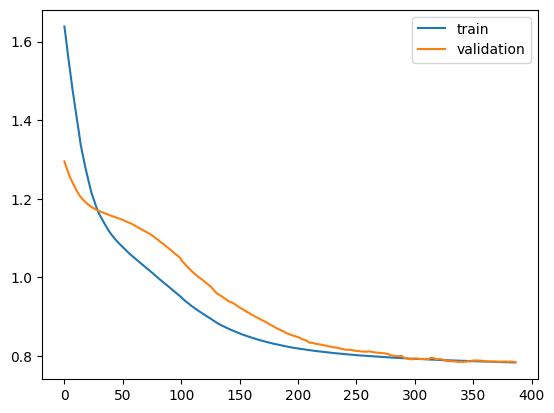

smape equals 10.352877826970717 with 1 time step as training
Train: 0.753, Test: 0.455


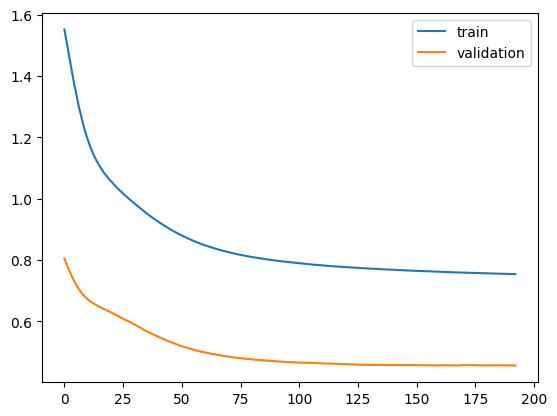

smape equals 7.608206189526181 with 2 time step as training
Train: 0.641, Test: 0.660


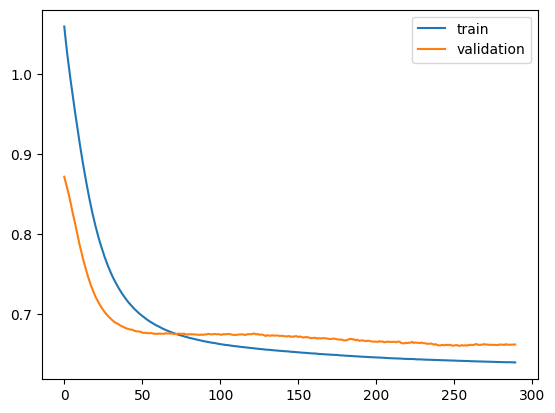

smape equals 9.91494300207506 with 3 time step as training
Train: 0.705, Test: 0.948


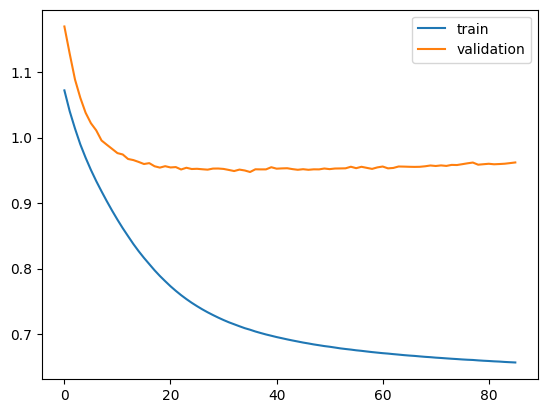

smape equals 12.860149630931069 with 4 time step as training
Train: 0.703, Test: 0.947


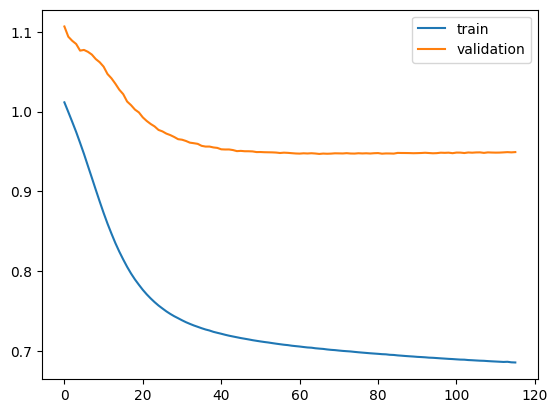

smape equals 13.247077879061354 with 5 time step as training


In [97]:
lays = [[10], [2,2], [3,2], [4,4,4], [10,10,10]]
epochs = [50]
batchSizes = [16]
activationFunctions = ['relu']

options = []

for layer in lays:
    for activation in activationFunctions:
        for batchSize in batchSizes:
                options.append([layer, activation, batchSize, 0, 0])


options = pd.DataFrame(options)
options = options.set_axis(['layers', 'activation', 'batchSize', 'averageSmape', 'varianceSmape'], axis=1)

# print(options.iloc[0].layers)

for i in range(len(options)):
    smape_avg=[]
    for j in range(1):
        smape_avg.append(kfolds(train, [1,2,3,4,5,6,7,8,9,10], options.iloc[i]))

    options.iat[i,3] = np.mean(smape_avg)
    options.iat[i,4] = np.std(smape_avg)


op = pd.DataFrame(options)
res = op.sort_values(by="averageSmape")
print(res)

In [ ]:
print(op.sort_values(by="averageSmape"))

In [ ]:
##Testing
df = pd.read_excel("M3C.xls")
df = df.iloc[:146,6:26]

df_test = df.iloc[:,1:14]

window_size = 3
n_predictions = 6

lays = [500,500]
epochs = [15]
batchsize = [16]
activation = ['sigmoid']

options = [lays, activation, batchsize, epochs, 0, 0]

model = build_model(x_train, y_train, x_validation, y_validation, window_size, options)

observations = []
PF = []

for p in range(n_predictions):  
    for index, row in df_test.iterrows():
        preprocessed, p = preprocess(np.array(row))
        PF.append(p)
        observations.append([preprocessed[11+p:],None, p, len(preprocessed)])
    x = []
    for i in range(len(observations)):
        x.append(observations[i][0])
    predictions = model.predict(x)
    print(predictions)

    

In [ ]:
options = [[5,3], "relu", 10, 100, 0,0] #[layer, activation, batchSize, epoch, 0, 0]


model = build_model(x_train, y_train, x_validation, y_validation, 3, options)
smape(model, validation)

In [ ]:
validation

In [ ]:
y = []
y_hat = []
details = []
offset = 7
for i in range(0,10):
    y.append(observations[i+offset][1])
    y_hat.append(y[i] + 0.4)
    details.append(observations[i+offset])

repY = []
repY_hat = []
smape = 0
for i in range(10):
    repY.append(reprocess(y[i], details[i]))
    repY_hat.append(reprocess(y_hat[i], details[i]))
    smape += smape_clean(repY[i], repY_hat[i])

smape /= len(repY)
print(smape)
pyplot.plot(repY, label='original')
pyplot.plot(repY_hat, label='altered')
pyplot.plot(df_train.iloc[1,3:10], label = 'og')
pyplot.legend()
pyplot.show()


